In [1]:
import math

import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import HTML, display,SVG
import pydot
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ControllabilityMatrix,
    DiagramBuilder,
    Linearize,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    AddDefaultVisualization,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
    Saturation,
    SceneGraph,
    Simulator,
    StartMeshcat,
    WrapToSystem,
    namedview,
    FiniteHorizonLinearQuadraticRegulatorOptions
)
from pydrake.examples import (
    AcrobotGeometry,
    AcrobotInput,
    AcrobotPlant,
    AcrobotState,
    QuadrotorGeometry,
    QuadrotorPlant,
    StabilizingLQRController,
)
from pydrake.solvers import MathematicalProgram, Solve

from underactuated import ConfigureParser, running_as_notebook
from underactuated.meshcat_utils import MeshcatSliders
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer
from underactuated.scenarios import AddFloatingRpyJoint

if running_as_notebook:
    mpld3.enable_notebook()

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


In [3]:
time_step = 1.0/60.0
test_mode = False

In [4]:
def create_quadrotor(quadrotor_builder, quadrotor_plant, scene_graph):

    # Define quadrotor MultiBodyPlant using Quadrotor .urdf and Propeller class
    (quad_model, ) = Parser(quadrotor_plant).AddModelsFromUrl(
        "package://drake/examples/quadrotor/quadrotor.urdf"
    )
    quad_body = quadrotor_plant.GetBodyByName("base_link")
    quad_frame = quadrotor_plant.GetFrameByName("base_link")
    #finalize the plant
    quadrotor_plant.Finalize()
    # set name
    quadrotor_plant.set_name("quadrotor_plant")

    # Define propellers
    prop_infos = []
    p_thrust_ratio = 1.0
    for i in range(1, 5):
        p_moment_ratio = -0.275 if i % 2 == 0 else 0.275
        p_pose = RigidTransform(p=[0.1750, 0, 0]) if i == 1 else \
                 RigidTransform(p=[0, 0.1750, 0]) if i == 2 else \
                 RigidTransform(p=[-0.1750, 0, 0]) if i == 3 else \
                 RigidTransform(p=[0, -0.1750, 0])
        prop_infos.append(PropellerInfo(quad_body.index(), p_pose, p_thrust_ratio, p_moment_ratio))
    props = quadrotor_builder.AddSystem(Propeller(prop_infos))
    quadrotor_builder.Connect(
            props.get_output_port(),
            quadrotor_plant.get_applied_spatial_force_input_port(),
        )
    quadrotor_builder.Connect(
        quadrotor_plant.get_body_poses_output_port(),
        props.get_body_poses_input_port(),
    )
    quadrotor_builder.ExportInput(props.get_command_input_port(), "prop_command")
    quadrotor_builder.ExportOutput(quadrotor_plant.get_state_output_port(), "state")

    # Set up visualization in MeshCat
    meshcat.Delete()
    meshcat.ResetRenderMode()
    meshcat.SetProperty('/Background','visible',False)
    visualizer = MeshcatVisualizer.AddToBuilder(quadrotor_builder, scene_graph, meshcat)

    quadrotor_diagram = quadrotor_builder.Build()

    return quadrotor_diagram, visualizer

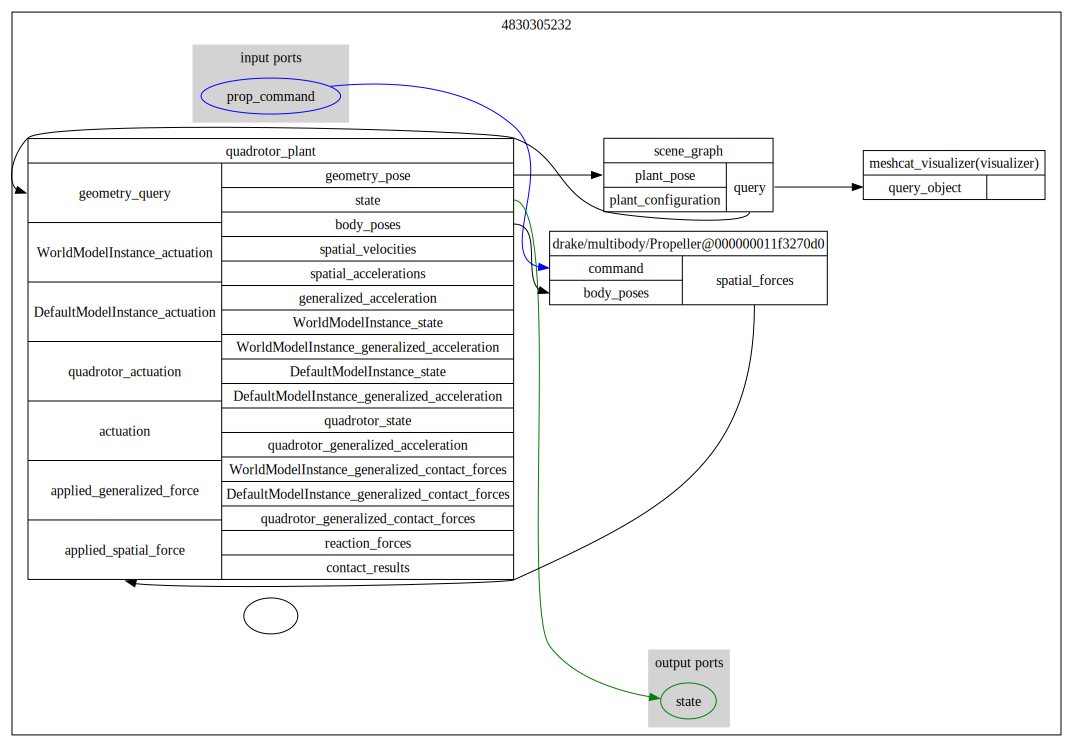

In [5]:
# Setup builder and scene.
quadrotor_builder = DiagramBuilder()
quadrotor_plant, scene_graph = AddMultibodyPlantSceneGraph(quadrotor_builder, time_step = 0.0)
quadrotor_diagram, visualizer = create_quadrotor(quadrotor_builder, quadrotor_plant, scene_graph)
svg_graph = pydot.graph_from_dot_data(quadrotor_diagram.GetGraphvizString(max_depth=1))[0].create_svg()
display(SVG(svg_graph))

In [8]:
# run the simulation with zero input
# setup simulation
simulator = Simulator(quadrotor_diagram)
simulator.set_target_realtime_rate(1.0)
# modify context
context = simulator.get_mutable_context()
context.SetTime(0.)
context.SetContinuousState([0.0]*3 + [1.0] + [0.0]*9)
# set the input to match the mass
quadrotor_plant = quadrotor_diagram.GetSubsystemByName("quadrotor_plant")
mass = quadrotor_plant.CalcTotalMass(quadrotor_plant.GetMyContextFromRoot(context))
gravity = quadrotor_plant.gravity_field().gravity_vector()[2]
thrust = - mass * gravity
quadrotor_diagram.get_input_port().FixValue(context, [thrust/4.0]*4)
# set quadrotor initial state
simulator.Initialize()
# start meshcat recording
visualizer.StartRecording()
simulator.AdvanceTo(4.0)
visualizer.StopRecording()
visualizer.PublishRecording()

In [ ]:
# setup LQR controller
Q = np.diag([10, 10, 10, 1, 1, 1, 1, 1, 1, 1])
R = np.diag([1, 1, 1, 1])
# set input to zero
context = quadrotor_diagram.CreateDefaultContext()
quadrotor_diagram.get_input_port(0).FixValue(context, np.zeros(4))
# Assuming quadrotor_diagram is your system diagram
context = quadrotor_diagram.CreateDefaultContext()
# Set continuous state to zero
continuous_state = context.get_mutable_continuous_state_vector()
continuous_state.SetFromVector(np.zeros(continuous_state.size()))
lqr = LinearQuadraticRegulator(quadrotor_diagram, context, Q, R)

In [ ]:
# connect everything with builder
global_builder = DiagramBuilder()
global_builder.AddSystem(quadrotor_diagram)
global_builder.AddSystem(lqr)
global_builder.Connect(quadrotor_diagram.get_output_port(0), lqr.get_input_port(0))
global_builder.Connect(lqr.get_output_port(0), quadrotor_diagram.get_input_port(0))
diagram = global_builder.Build()